# HW2: Model Inference of the Pretrained LeNet

<font color='red'>Name: 潘勝元 Student ID: 109062116 </font>

## 1. Data preparation


### Build a QAT network (with our customized configuration) and train.

In [91]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import OrderedDict
import numpy as np
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [92]:
def train(model: nn.Module, dataloader: DataLoader, num_epoch):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader):
            
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.requires_grad_()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print(test(model, testloader, None))
    print('Finished Training')
    
def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += inputs.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total



In [93]:
class LeNet5QAT(nn.Module):
    def __init__(self):
        super(LeNet5QAT, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(1, 6, 5, bias=False)),
            ('relu', nn.ReLU()),
        ]))
        
        self.maxpool2 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv3 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(6, 16, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.maxpool4 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv5 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(16, 120, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.fc6 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(120, 84, bias=False)),
            ('relu', nn.ReLU())
        ]))
        
        self.output = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(84, 10, bias=True)),
        ]))
        
        self.quant = quant.QuantStub()
        self.dequant = quant.DeQuantStub()
        
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.output(x)
        x = self.dequant(x)
        
        return x


In [94]:
qcfg = torch.quantization.get_default_qat_qconfig('qnnpack')
qact = torch.quantization.FakeQuantize.with_args(observer=torch.quantization.MovingAverageMinMaxObserver,
                             quant_min=-128, quant_max=127, dtype=torch.qint8,
                             qscheme=torch.per_tensor_symmetric, reduce_range=False)
qcfg = torch.quantization.QConfig(activation=qact, weight=qcfg.weight)

In [95]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g,)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g,)

* You should comment out `train(model, trainloader, 1)` and uncomment `model.load_state_dict(torch.load('qat_prepare.pt'))` before submitting your homework.
    * Also, reloading the model from `qat_prepare.pt` can save your time if there is something wrong and you need to restart and run all.

In [96]:
import torch.quantization as quant

# define the model
model = LeNet5QAT().to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare the model for QAT
model.train()
torch.backends.quantized.engine = 'qnnpack'
model.qconfig = qcfg
torch.quantization.prepare_qat(model, inplace=True)

model.load_state_dict(torch.load('qat_prepare.pt'))
#train(model, trainloader, 1)
torch.save(model.state_dict(), 'qat_prepare.pt')

# convert the model to a quantized model
torch.quantization.convert(model, inplace=True)

# evaluate the model on the test set
model.eval()


device=torch.device('cpu')
score = test(model, testloader)
print('Accuracy of the quantized LeNet-5 model on the test images: {}%'.format(score))

Accuracy of the quantized LeNet-5 model on the test images: 98.31%


### Extract weight, floating-point bias and floating-point scale of activations and weights of every layer.

In [97]:
import os 
import zipfile
# It is easier to download all the files with zip
zf = zipfile.ZipFile('parameters.zip', 'w', zipfile.ZIP_DEFLATED)

In [98]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
if not os.path.exists('./float_scale'):
    os.mkdir('./float_scale')
    
for name, weights in model.state_dict().items():
    name_split = name.split('.')
    if(weights!= None):
      if(name_split[-2] != "_packed_params"):
        if(weights.type()== "torch.quantized.QInt8Tensor" or weights.type()== "torch.quantized.QUInt8Tensor"):
          np.savetxt('./weights/%s.csv' %(name) , weights.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          zf.write('./weights/%s.csv' %(name))

          np.savetxt('./float_scale/%s.scale.csv' %(name) , np.array([weights.q_scale()]), delimiter=',')

          np.savetxt('./float_scale/%s.zero_point.csv' %(name) , np.array([weights.q_scale()]), delimiter=',')
        else:
          np.savetxt('./float_scale/%s.csv' %(name) , weights.cpu().numpy().reshape(-1).astype(float), delimiter=',')

      elif(name_split[-1] == "_packed_params"):
        if not os.path.exists('./weights/_packed_params'):
          os.mkdir('./weights/_packed_params')
        name = name_split[0]+"."+name_split[1]
        weight, bias = weights
        if(weight.type()== "torch.quantized.QInt8Tensor" or weight.type()== "torch.quantized.QUInt8Tensor"):
          np.savetxt('./weights/%s.weight.csv' %(name)  , weight.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          zf.write('./weights/%s.weight.csv' %(name))

          np.savetxt('./float_scale/%s.weight.scale.csv' %(name) , np.array([weight.q_scale()]), delimiter=',')

          np.savetxt('./float_scale/%s.weight.zero_point.csv' %(name) , np.array([weight.q_zero_point()]), delimiter=',')
        
        if(bias != None):
          
          if(bias.type()== "torch.quantized.QInt8Tensor" or bias.type()== "torch.quantized.QUInt8Tensor"):
            np.savetxt('./float_scale/%s.bias.csv' %(name) , bias.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          else:
            np.savetxt('./float_scale/%s.bias.csv' %(name) , bias.cpu().detach().numpy().reshape(-1).astype(float), delimiter=',')
          

### 1.1 Caculate the fixed-point output scale of the QAT model
In function `float_to_fixed_scale()`, first you need to calculate fixed-point scales $M_{l}$, which is something like $S_l$ in `homework1.ipynb`. Store them in the `scalesDict` dictionary. Second,  calculate a revised value for the `outputBias` variable.


In the front, we extract the scales of input, output, and weight  for each layer from the model. By [pytorch Quantized Tensor](https://pytorch.org/docs/stable/quantization.html), the scaling factor of the input matrix $I_{l}$,  weight matrix $W_{l}$ and output matrix $O_{l}$ are denoted by $s_{W_{l}}$, $s_{I_{l}}$ and $s_{O_{l}}$ , respectively, for each layer ${l}$. The corresponding quantized 8-bit signed integer tensors are denoted by $I_{l_q}$, $W_{l_q}$ and $O_{l_q}$. Note that the definition here is a bit different from our `homework1.ipynb`:
$$I_l = I_{l_q} * s_{I_{l}},$$
$$W_l = W_{l_q} * s_{W_{l}},$$
$$O_l = O_{l_q} * s_{O_{l}}.$$

In `float_to_fixed_scale()` TODO, we need to caculate $M_{l}$ and save them in `scalesDict` where in layer $l$, 
$$W_{l_q}* I_{l_q} * M_{l} \approx O_{l_q} = I_{{l+1}_q}$$
As for the initial input, we need to caculate $M_{quant}$ where
$$I_{initialInput} * M_{quant} \approx O_{{initialInput}_q} = I_{{conv1.conv}_q}$$
*   hint: `act_scalesDict[layerName]` store the output activation scale, i.e., $s_{O_{l}}$ in the above equation, and it is also the input activation scale of the next layer $s_{I_{l+1}}$.



To simplify the hardware implementation, let's convert $M_{l}$ into integer by multiplying `2**16` and rounding it. As for the initial input, you can simply round it since $M_{quant}$ is much greater than 1.

In addition, you need to adjust the `outputBias` value to ensure that it remains unchanged when we use $M_{output}$ for requantization.

In [99]:
def float_to_fixed_scale():
    scalesDict = {}
    act_scalesDict = {}
    weight_scalesDict = {}
    outputBias = []
    
    layerName = ["conv1.conv", "conv3.conv", "conv5.conv", "fc6.fc", "output.fc"] 
    for key in layerName:
        Arr = np.loadtxt('./float_scale/'+key+".weight.scale.csv",
                         delimiter=',').reshape(([1])).astype(float)
        weight_scalesDict[key] = Arr

        Arr = np.loadtxt('./float_scale/'+key+".scale.csv",
                         delimiter=',').reshape(([1])).astype(float)
        act_scalesDict[key] = Arr

    act_scalesDict["quant"] = np.loadtxt("./float_scale/quant.scale.csv",
                      delimiter=',').reshape(([1])).astype(float)
    outputBias = np.loadtxt(
        './float_scale/'+key+".bias.csv", delimiter=',').reshape(([1, 10])).astype(float)
    
    
    scalesDictName = ["quant", "conv1.conv", "conv3.conv", "conv5.conv", "fc6.fc", "output.fc"] 
    
    # TODO
    pre = 0
    for i in scalesDictName:
      if(i == "quant"):
        S = act_scalesDict[i].item()
        scalesDict[i] = round(1/S)
        pre = S
      else:
        sOI = act_scalesDict[i].item()
        sWI = weight_scalesDict[i].item()
        scalesDict[i] = round(pre * sWI / sOI * (2 ** 16))
        pre = sOI
    outputBias = (outputBias * 2**16 / scalesDict[i] ).astype(int)
    return scalesDict, outputBias


In [100]:
import json
scalesDict, outputBias = float_to_fixed_scale()
with open('fixed_scale.json', 'w', newline='') as jsonfile:
    json.dump(scalesDict, jsonfile)
zf.write('./fixed_scale.json')


np.savetxt('./weights/output.fc.bias.csv', outputBias, delimiter=',')
zf.write('./weights/output.fc.bias.csv')

### Reconstruct the model with build-in function and extract the input and output of layer.

In [101]:
def getWeightAndScale():
    weightsDict = {}
    shapeDict = {"conv1.conv": [6, 1, 5, 5],
                 "conv3.conv": [16, 6, 5, 5],
                 "conv5.conv": [120, 16, 5, 5], 
                 "fc6.fc": [84, 120],
                 "output.fc": [10, 84]
                 }

    for key in shapeDict:
        Arr = np.loadtxt('./weights/'+key+".weight.csv",
                         delimiter=',').astype(int)
        shape = shapeDict[key]
        Arr = Arr.reshape(([i for i in shape]))
        weightsDict[key] = Arr

    weightsDict["outputBias"] = np.loadtxt(
        './weights/'+key+".bias.csv", delimiter=',').reshape(([1, 10])).astype(float)
    
    scalesDict = {}
    with open('fixed_scale.json') as json_file:
        scalesDict = json.load(json_file)
    for i in scalesDict:
      scalesDict[i] = np.array([scalesDict[i]])

    return weightsDict, scalesDict

In [102]:
class QAT(nn.Module):
    def __init__(self):
        super(QAT, self).__init__()
        self.weightsDict, self.scalesDict = getWeightAndScale()

        self.conv1 = nn.Conv2d(1, 6, 5, bias=False)
        self.conv1.weight.data = torch.from_numpy(self.weightsDict["conv1.conv"]).float()
        
        self.maxpool2 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv3 = nn.Conv2d(6, 16, 5, bias=False)
        self.conv3.weight.data = torch.from_numpy(self.weightsDict["conv3.conv"]).float()

        self.maxpool4 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))
        
        self.conv5 = nn.Conv2d(16, 120, 5, bias=False)
        self.conv5.weight.data = torch.from_numpy(self.weightsDict["conv5.conv"]).float()

        
        self.fc6 = nn.Linear(120, 84, bias=False)
        self.fc6.weight.data = torch.from_numpy(self.weightsDict["fc6.fc"]).float()

        self.output = nn.Linear(84, 10, bias=True)
        self.output.weight.data = torch.from_numpy(self.weightsDict["output.fc"]).float()
        self.output.bias.data = torch.from_numpy(self.weightsDict["outputBias"].reshape(1, 10)).float()
        
    def forward(self, x):
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["quant"]), 
                  torch.tensor(0), torch.qint32).int_repr(), -128, 127).float()
        x = self.conv1(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv1.conv"]), 
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float() 
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv3.conv"]), 
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float() 

        x = self.maxpool4(x)
        x = self.conv5(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv5.conv"]), 
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float()
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["fc6.fc"]), 
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float() 
              
        x = self.output(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["output.fc"]), 
                  torch.tensor(0), torch.qint32).int_repr() >> 16, -128, 127) 
            
        
        return x

If you’ve done everything correctly, the accuracy degradation should be negligible(~1%).

In [103]:
qat = QAT()
score = test(qat, testloader)
print('Accuracy of the network with fixed point scale: {}%'.format(score))

Accuracy of the network with fixed point scale: 98.28%


In [104]:
def visualize_activations(module, input, output):
    if module.profile_activations == True:
        module.inAct = input[0].cpu().reshape(-1)
        module.outAct = output[0].cpu().reshape(-1)

In [105]:
# random choose images as the input and get the output
np.random.seed(0)
index = np.random.randint(0,len(trainset), size=100)
index = range(100)

In [106]:
if not os.path.exists('./activations'):
    os.mkdir('./activations')
for ind in range(100):
    if not os.path.exists('./activations/img{}'.format(ind)):
        os.mkdir('./activations/img{}'.format(ind))

    for name, model in qat.named_children():
        model.profile_activations = True
        model.register_forward_hook(visualize_activations)
    input0, label = testset[index[ind]]
    input = input0.reshape(1, 1, 32, 32)
    output = qat(input)
    for name, model in qat.named_children(): model.profile_activations = False 
    

    np.savetxt('./activations/img{}/input.csv'.format(ind), input.cpu().data.numpy().reshape(-1), delimiter=',')
    np.savetxt('./activations/img{}/output.csv'.format(ind), output.cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
    zf.write('./activations/img{}/input.csv'.format(ind))
    zf.write('./activations/img{}/output.csv'.format(ind))
    
    opDict = {
        'conv1': (qat.conv1.inAct, qat.conv1.outAct),
        'maxpool2': (qat.maxpool2.inAct, qat.maxpool2.outAct),
        'conv3': (qat.conv3.inAct, qat.conv3.outAct),
        'maxpool4': (qat.maxpool4.inAct, qat.maxpool4.outAct),
        'conv5': (qat.conv5.inAct, qat.conv5.outAct),
        'fc6': (qat.fc6.inAct, qat.fc6.outAct),
        'output': (qat.output.inAct, qat.output.outAct)
    }
    
    for key in opDict:
        if not os.path.exists('./activations/img{}/{}'.format(ind, key)):
            os.mkdir('./activations/img{}/{}'.format(ind, key))
        if(opDict[key][0].type()== "torch.quantized.QInt8Tensor" or opDict[key][0].type()== "torch.quantized.QUInt8Tensor"):
            temp = opDict[key][0].cpu().int_repr()
        else:
            temp = opDict[key][0].cpu()
        if(opDict[key][1].type()== "torch.quantized.QInt8Tensor" or opDict[key][1].type()== "torch.quantized.QUInt8Tensor"):
            temp1 = opDict[key][1].cpu().int_repr()
        else:
            temp1 = opDict[key][1].cpu()                
        np.savetxt('./activations/img{}/{}/input.csv'.format(ind, key), temp.data.numpy().reshape(-1).astype(float), delimiter=',')
        np.savetxt('./activations/img{}/{}/output.csv'.format(ind, key), temp1.cpu().data.numpy().reshape(-1).astype(float), delimiter=',')
        zf.write('./activations/img{}/{}/input.csv'.format(ind, key))
        zf.write('./activations/img{}/{}/output.csv'.format(ind, key))

In [107]:
zf.close()

## 2. High-level Function Implementation for Each Layer
Implement a high-level functional model for each layer of the CNN, including convolution, pooling, and 
fully-connected layer with 8-bit quantization of the input activations, output activations, and weights accordingly.
* Learn how to use [Numba](https://numba.pydata.org/) to accelerate python functions
* Fill in the TODOs in `functional.py` of `nnutils`.
    * You must consider `psum_range = (lower_bound, upper_bound)` which controls the precision of partial sums.
    * `psum_record_list` will be used in *2. Bit-width of Partial Sums*, so you may leave it alone for now.
    
### 2.1 Pass all Unit Tests of `OpTestCase`.
First, use 32-bit signed integers for the partial sums to pass the unit tests. The accumulation of activations is limited to 32 bits in convolution and fully-connected layers. Clamp the value if it exceeds the minimum or maximum values of the 32-bit signed number.

Note that you should implement convolution layers, fully-connected layers, and max-pooling layers with "nested loops" by yourself. You are not allowed to use existing functions (e.g., `conv2d` in `numpy` or `pytorch`). Or you will not get any credits. Raise questions when in doubt.

There are eight unit tests you need to pass. If you intend to run part of them, follow the steps:
```
tests = ['test_C1', 'test_C3']
suite = unittest.TestSuite(map(OpTestCase, tests))
```

In [108]:
#!pip install numba==0.55.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import unittest

class OpTestCase(unittest.TestCase):
    
    def setUp(self):
        bit = 32
        self.number_range = (-(2**(bit-1)), 2**(bit-1) - 1)
        self.weightsDict, self.scalesDict = getWeightAndScale()
        self.max_samples = 100 #100
        
        
    def tearDown(self):
        self.weightsDict, self.scalesDict = None, None
        self.source = None
         
    def test_C1(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv1/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 1, 32, 32)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv1.conv"], out_channels=6)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv1/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_ACTQUANT(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv1/output.csv", delimiter=',').astype(int)
            x = ActQuant(x, self.scalesDict["conv1.conv"])
            x = ReLU(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool2/input.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_S2(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/maxpool2/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 6, 28, 28)
            x = MaxPool2d(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool2/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))
    
    def test_C3(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)         
            x = np.loadtxt(self.source+"/conv3/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 6, 14, 14)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv3.conv"], out_channels=16)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv3/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))
    
    def test_S4(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)         
            x = np.loadtxt(self.source+"/maxpool4/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 16, 10, 10)
            x = MaxPool2d(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool4/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))
            
    def test_C5(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)             
            x = np.loadtxt(self.source+"/conv5/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 16, 5, 5)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv5.conv"], out_channels=120)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv5/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))
    
    def test_F6(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)             
            x = np.loadtxt(self.source+"/fc6/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 120)
            x, _ = Linear(self.number_range, x, self.weightsDict["fc6.fc"])
            x_ = np.loadtxt(self.source+"/fc6/output.csv", delimiter=',')
            self.assertTrue(np.all(x == x_))
            
    def test_OUTPUT(self):
        for i in range(1,self.max_samples):
            self.source = "./activations/img{}/".format(i)             
            x = np.loadtxt(self.source+"/output/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 84)
            x, _ = Linear(self.number_range, x, self.weightsDict["output.fc"], self.weightsDict["outputBias"])
            x_ = np.loadtxt(self.source+"/output/output.csv", delimiter=',')
            self.assertTrue(np.all(x == x_))


In [110]:
#@title
import numba as nb
import json

@nb.jit()
def MaxPool2d(x, kernel_size=2, stride=2):
    N, C, H, W = x.shape
    x_out = np.zeros((N, C, int(((H-kernel_size)/stride)+1),
                     int((W-kernel_size)/stride + 1)), dtype='int32')
    # TODO
    for n in range(N):
      for c in range(C):
        for h in range(int(((H-kernel_size)/stride)+1)):
          for w in range(int((W-kernel_size)/stride + 1)):
            val = 0
            for i in range(kernel_size):
              for j in range(kernel_size):
                x_out[n,c,h,w] = max(x[n,c,h*stride+i,w*stride+j],x_out[n,c,h,w])
    return x_out


@nb.jit()
def ReLU(x):
    # TODO
    x = np.where(x>0,x,0)
    return x


@nb.jit()
def Linear(psum_range, x, weights, weightsBias=None, psum_record=False):
  psum_record_list = [np.complex64(x) for x in range(0)]
  H, W = x.shape
  C = weights.shape[0]
  x_out = np.zeros((H, C))
  # TODO
  for h in range(H):
    for c in range(C):
      for w in range(W):
        x_out[h,c] = x_out[h,c]+x[h,w]*weights[c,w]
      if(x_out[h,c]>psum_range[1]):
        x_out[h,c] = psum_range[1]
      elif(x_out[h,c]<psum_range[0]):
        x_out[h,c] = psum_range[0]
      if(psum_record==True):
        psum_record_list.append(x_out[h,c])
  if (weightsBias!=None):
    x_out = x_out + weightsBias
  return x_out, psum_record_list


@nb.jit()
def Conv2d(psum_range, x, weights, out_channels, kernel_size=5, stride=1, bias=False, psum_record=False):
    psum_record_list = [np.complex64(x) for x in range(0)]
    N, C, H, W = x.shape
    x_out = np.zeros((N, out_channels, int(((H-kernel_size)/stride)+1),
                     int((W-kernel_size)/stride + 1)))
    # TODO
    for n in range(N):
      for c in range(out_channels):
        for h in range(int(((H-kernel_size)/stride)+1)):
          for w in range(int((W-kernel_size)/stride + 1)):
            result = 0
            for i in range(kernel_size):
              for j in range(kernel_size):
                product = 0
                for k in range(C):
                  product = product+x[n, k, h*stride+i, w*stride+j] * weights[c, k, i, j]
                result = result+product
            x_out[n, c, h, w] = result
            if(x_out[n, c, h, w]>psum_range[1]):
              x_out[n, c, h, w] = psum_range[1]
            elif(x_out[n, c, h, w]<psum_range[0]):
              x_out[n, c, h, w] = psum_range[0]
            if(psum_record==True):
              psum_record_list.append(x_out[n, c, h, w])
    return x_out, psum_record_list


def ActQuant(x, scale, shiftbits=16):
    # TODO
    x = np.round((x * scale))
    x = np.floor(x / 2**shiftbits)
    x = np.where(x>127,127,x)
    x = np.where(x<-128,-128,x)
    return x


In [111]:
tests = ['test_C5']
suite = unittest.TestSuite(map(OpTestCase, tests))
suite = unittest.TestLoader().loadTestsFromTestCase(OpTestCase)
unittest.TextTestRunner(verbosity=2).run(suite)

test_ACTQUANT (__main__.OpTestCase) ... ok
test_C1 (__main__.OpTestCase) ... ok
test_C3 (__main__.OpTestCase) ... ok
test_C5 (__main__.OpTestCase) ... ok
test_F6 (__main__.OpTestCase) ... ok
test_OUTPUT (__main__.OpTestCase) ... ok
test_S2 (__main__.OpTestCase) ... ok
test_S4 (__main__.OpTestCase) ... ok

----------------------------------------------------------------------
Ran 8 tests in 20.461s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

### 2.2 Reconstruct the LeNet in HW1
* Fill in the TODO in `forward()` of `LeNet`.
* Test the model with the test dataset. There should be no accuracy degradation if you have done everything correctly.

In [112]:
class LeNet:

    def __init__(self, psum_range_dict):
        self.psum_range = psum_range_dict
        self.weightsDict, self.scalesDict = getWeightAndScale()
        self.psum_record_dict = {}
        
    def forward(self, x, psum_record=False):
      # TODO
      # You should get the record of partial sums by `x, self.psum_record_dict['c1'] = Conv2d(...)`.
      x = ActQuant(x,self.scalesDict["quant"],0)
      x,self.psum_record_dict['c1'] = Conv2d(self.psum_range["c1"],x,self.weightsDict["conv1.conv"],6,psum_record=psum_record)
      x = ActQuant(x,self.scalesDict["conv1.conv"])
      x = ReLU(x)
      x = MaxPool2d(x)
      x,self.psum_record_dict['c3'] = Conv2d(self.psum_range["c3"],x,self.weightsDict["conv3.conv"],16,psum_record=psum_record)
      x = ActQuant(x,self.scalesDict["conv3.conv"])
      x = ReLU(x)
      x = MaxPool2d(x)
      x,self.psum_record_dict['c5'] = Conv2d(self.psum_range["c5"],x,self.weightsDict["conv5.conv"],120,psum_record=psum_record)
      x = ActQuant(x,self.scalesDict["conv5.conv"])
      x = ReLU(x)
      
      x = np.reshape(x, (x.shape[0], -1))
      x,self.psum_record_dict['f6'] = Linear(self.psum_range["f6"],x,self.weightsDict["fc6.fc"],psum_record=psum_record)
      x = ActQuant(x,self.scalesDict["fc6.fc"])
      x = ReLU(x)
            
      x,self.psum_record_dict['output'] = Linear(self.psum_range["output"],x,self.weightsDict["output.fc"],self.weightsDict["outputBias"],psum_record=psum_record)
      x = ActQuant(x,self.scalesDict["output.fc"]) 
      
      return x

In [113]:
def test(model, dataloader: DataLoader, max_samples=None):
    cnt = 0
    total = 0
    n_inferences = 0
    for i, data in enumerate(dataloader):

        images, labels = data[0].numpy(), data[1].numpy()
        y = model.forward(images)

        y = np.argmax(y, axis=1)
        cnt = cnt + np.count_nonzero((labels == y) == True)
        total += images.shape[0]

        if max_samples:
            n_inferences += images.shape[0]
            if n_inferences >= max_samples:
                break

    print("Accuracy: {}%".format(cnt/total*100))
    return cnt/total*100

In [114]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

def run_LeNet(n_bit, max_samples = None):
    number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
    print("bit:", n_bit)
    print("bit-width range:",number_range)

    psum_range = {
        'c1': number_range,
        'c3': number_range,
        'c5': number_range,
        'f6': number_range,
        'output': number_range
    }

    model = LeNet(psum_range)

    return test(model, testloader)

run_LeNet(n_bit = 32)

bit: 32
bit-width range: (-2147483648, 2147483647)
Accuracy: 98.28%


98.28

## 3. Bit-width of Partial Sums
### 3.1 Question: Find the minimum bit-width of partial sums for all layers with the highest accuracy
1. Use matplotlib to plot "Test Accuracy(%)" versus "Bit-width of Partial Sums" for "Bit-width of Partial Sums" in $[2, 32]$ by `matplotlib.pyplot.plot()`.
    * [Plot with matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html).
2. What is the smallest bit-width of partial sums that maintains the same accuracy from the previous plot?

### 3.1 Answers
<font color='red'>Write your answers here.</font>
1. y軸是Test Accuracy(%)，x軸是bit-width
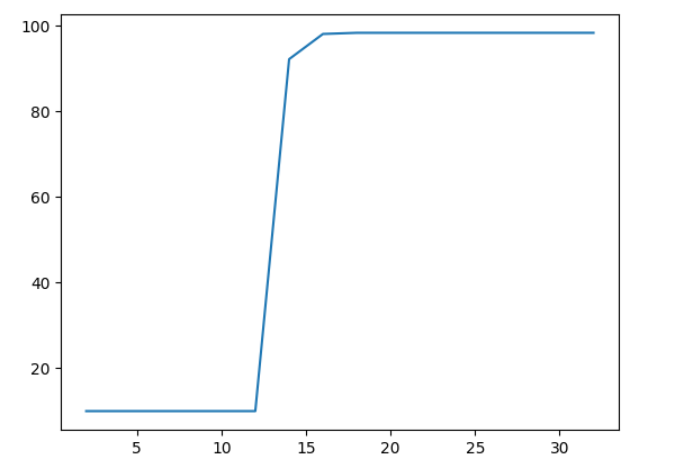
2. 18 bit-width時

bit: 2
bit-width range: (-2, 1)
Accuracy: 9.8%
bit: 4
bit-width range: (-8, 7)
Accuracy: 9.8%
bit: 6
bit-width range: (-32, 31)
Accuracy: 9.8%
bit: 8
bit-width range: (-128, 127)
Accuracy: 9.8%
bit: 10
bit-width range: (-512, 511)
Accuracy: 9.8%
bit: 12
bit-width range: (-2048, 2047)
Accuracy: 9.8%
bit: 14
bit-width range: (-8192, 8191)
Accuracy: 92.12%
bit: 16
bit-width range: (-32768, 32767)
Accuracy: 98.00999999999999%
bit: 18
bit-width range: (-131072, 131071)
Accuracy: 98.28%
bit: 20
bit-width range: (-524288, 524287)
Accuracy: 98.28%
bit: 22
bit-width range: (-2097152, 2097151)
Accuracy: 98.28%
bit: 24
bit-width range: (-8388608, 8388607)
Accuracy: 98.28%
bit: 26
bit-width range: (-33554432, 33554431)
Accuracy: 98.28%
bit: 28
bit-width range: (-134217728, 134217727)
Accuracy: 98.28%
bit: 30
bit-width range: (-536870912, 536870911)
Accuracy: 98.28%
bit: 32
bit-width range: (-2147483648, 2147483647)
Accuracy: 98.28%


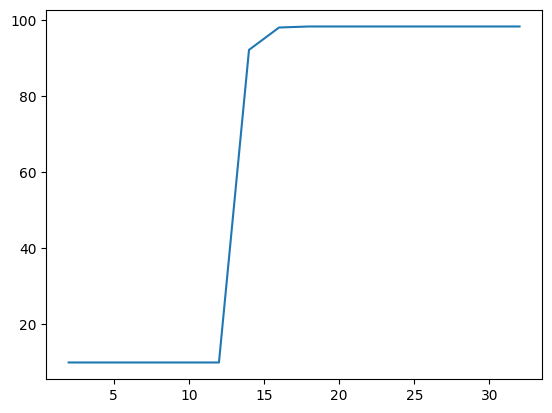

In [115]:
import matplotlib.pyplot as plt
acc = []
for i in range(1, 17):
    acc.append(run_LeNet(i*2))
    
# TODO   
plt.plot([range(2,33,2)][0],acc)
plt.show()

### 3.2 Question: Find the minimum bit-width of partial sums for each layer with the highest accuracy
1. Plot the distribution of partial sums of each quantized layer in the CNN with the MNIST test dataset. Write down the min, max, and standard deviation for each layer. 
    * Check the TODO in `LeNet` of `LeNetModel`. You should save all partial sums to the dictionary, `psum_record_dict`.
    * We can get this dictionary after running the model with the first image in the test dataset by `model.psum_record_dict`.
2. Determine the minimum bit-width of partial sums in each layer without hurting the accuracy. 
    * Fill in the TODO to see if the accuracy is still the same.
    * Show the accuracy after doing so.

### 3.2 Answers
<font color='red'>Write your answers here.</font>
1.由上往下有六層  
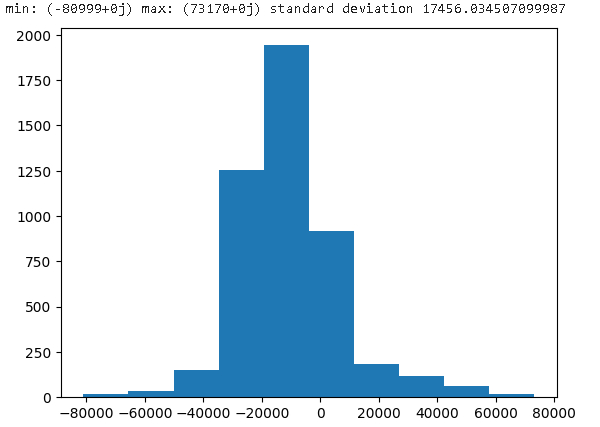  
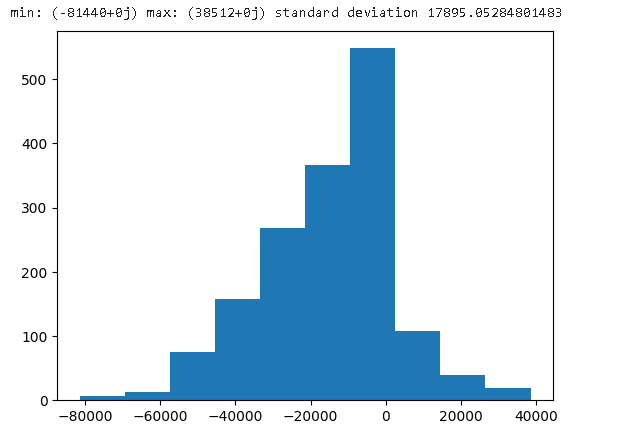  
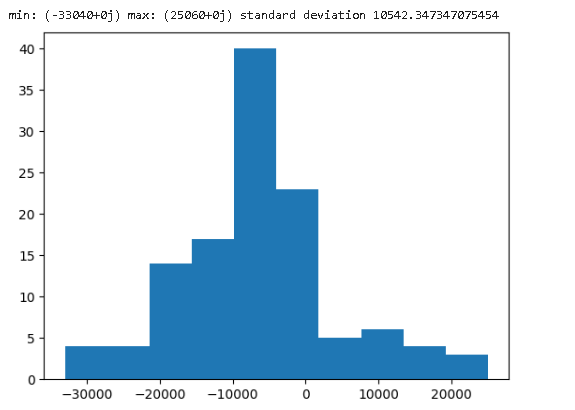  
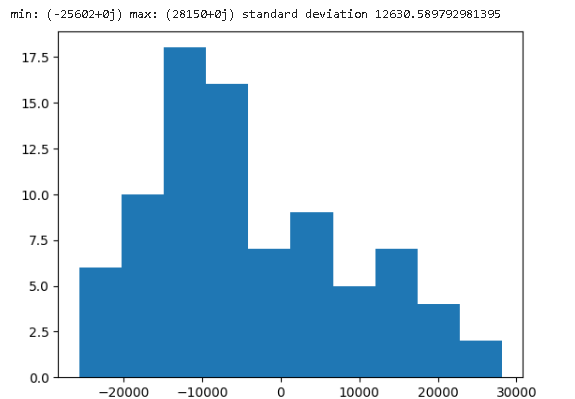  
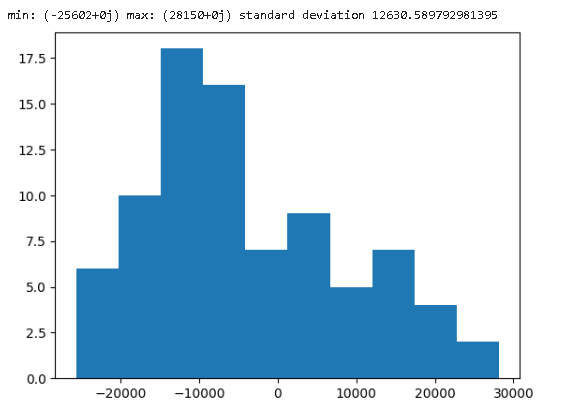  
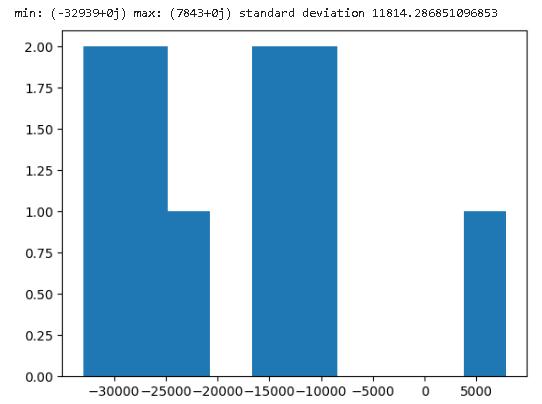
2. 有改動的層數下: 
  第一層是18bit width  
  第二至四層是16bit width
  第五層是14 bit width

bit: 32
bit-width range: (-2147483648, 2147483647)


/usr/local/lib/python3.9/dist-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


min: (-80999+0j) max: (73170+0j) standard deviation 17456.034507099987


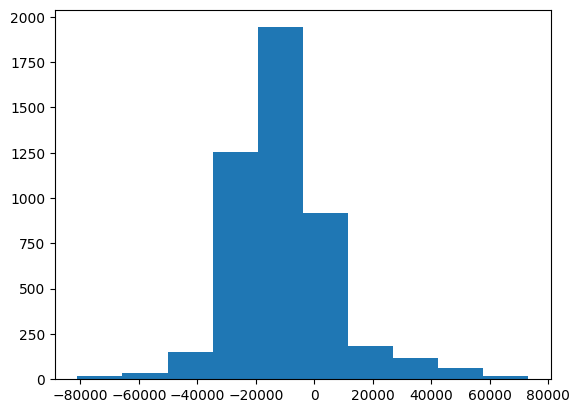

min: (-81440+0j) max: (38512+0j) standard deviation 17895.05284801483


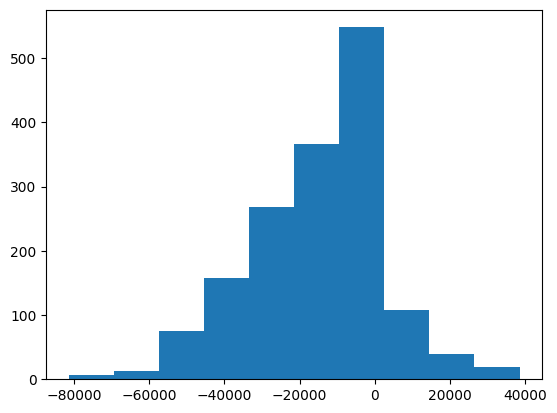

min: (-33040+0j) max: (25060+0j) standard deviation 10542.347347075454


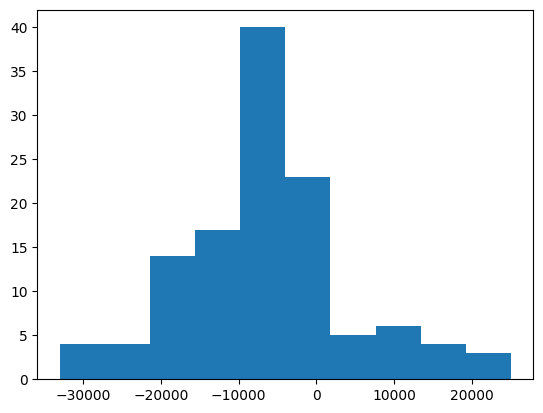

min: (-25602+0j) max: (28150+0j) standard deviation 12630.589792981395


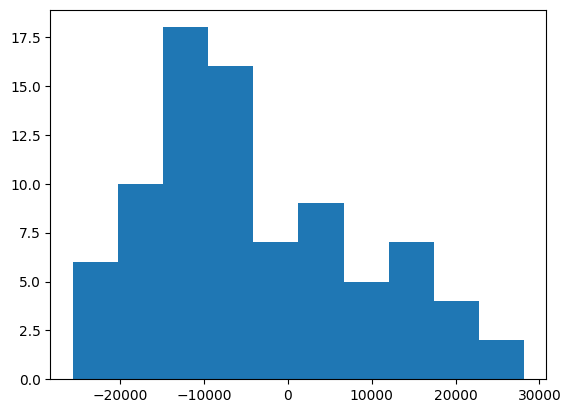

min: (-32939+0j) max: (7843+0j) standard deviation 11814.286851096853


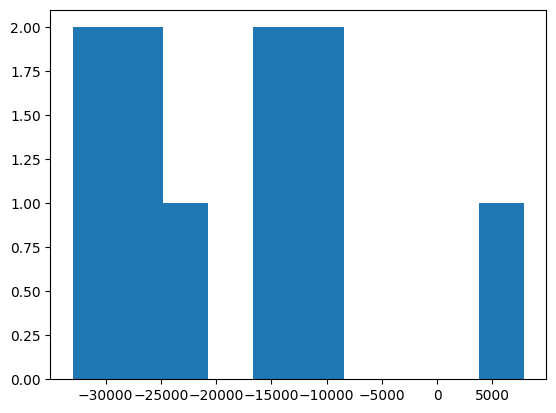

In [116]:
import matplotlib.pyplot as plt
n_bit = 32
number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
print("bit:", n_bit)
print("bit-width range:",number_range)

psum_range = {
    'c1': number_range,
    'c3': number_range,
    'c5': number_range,
    'f6': number_range,
    'output': number_range
}

model = LeNet(psum_range)

image = np.expand_dims(testset[0][0], axis=0)
_ = model.forward(image, psum_record = True)

# TODO
# Plot the distribution of partial sums of each quantized layer in the CNN
plt.figure(1)
C1 = model.psum_record_dict['c1']
plt.hist(C1)
print("min:",np.min(C1),"max:",np.max(C1),"standard deviation",np.std(C1))
plt.show()
plt.figure(2)
C3 = model.psum_record_dict['c3']
plt.hist(C3)
print("min:",np.min(C3),"max:",np.max(C3),"standard deviation",np.std(C3))
plt.show()
plt.figure(3)
C5 = model.psum_record_dict['c5']
plt.hist(C5)
print("min:",np.min(C5),"max:",np.max(C5),"standard deviation",np.std(C5))
plt.show()
plt.figure(4)
F6 = model.psum_record_dict['f6']
plt.hist(F6)
print("min:",np.min(F6),"max:",np.max(F6),"standard deviation",np.std(F6))
plt.show()
plt.figure(5)
OUT = model.psum_record_dict['output']
plt.hist(OUT)
print("min:",np.min(OUT),"max:",np.max(OUT),"standard deviation",np.std(OUT))
plt.show()

In [117]:
# TODO
# Test your model with those Bit-widths you choose
n_bit = 18
number_range1 = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
n_bit = 16
number_range3 = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
n_bit = 16
number_range5 = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
n_bit = 16
number_range6 = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
n_bit = 14
number_rangeo = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
psum_range = {
    'c1': number_range1, #18
    'c3': number_range3, #16
    'c5': number_range5,  #16
    'f6': number_range6,  #16
    'output': number_rangeo #14
}

model = LeNet(psum_range)

_ = test(model, testloader)


Accuracy: 98.28%


## 4. Evaluation: Energy Model
### 4.1 Question: Evaluate these two approaches based on the following energy model:
$$E_w = s_{mul}\times N_{mul} + s_{add}\times N_{add},$$
$$s_{mul} = \alpha\times \left(\frac{B_{mul}}{8}\right)^2,\ \alpha = 64,$$
$$s_{add} = \beta\times B_{add}, \ \beta=1,$$
The variables $N_{mul}$ and $N_{add}$ represent the number of multiplications and additions in your dataflow, respectively. It's possible to calculate the $N_{mul}$ and $N_{add}$ of each layer by hand. The variables $B_{mul}$ and $B_{add}$ denote the bit-widths of multiplier and adder, respectively. The constants α and β are provided to model the energy scaling factor of multiplication and addition, respectively. Additionally, $s_{mul}$ represents the energy cost per multiplication, which is proportional to the square of the multiplier’s bit-width. On the other hand, $s_{add}$ denotes the energy cost per addition, which is linearly proportional to the adder’s bit-width. For instance, in our estimation model, a 4-bit multiplier has an energy cost per multiplication of 16, which is computed as 64 x (4/8)^2.
* You must accumulate the energy layer by layer to obtain the overall $E_w$, if each layer has a  different $B_{mul}$ or $B_{add}$.
* We only consider convolution and fully-connected operations, ignoring pooling and ReLU operations in this energy model.
* Disclaimer: Note that this energy model is artificial and oversimplified. DO NOT apply it to your research work.

1. Calculate the overall $E_w$ with minimum bit-width for the setup of 3.1.
2. Calculate the energy layer by layer and also the overall $E_w$ for the setup of 3.2.

### 4.1 Answers
<font color='red'>Write your answers here.</font>
1. 設定X = N*out_channels*(((H-kernel_size)/stride)+1)*  
(((W-kernel_size)/stride)+1)*(kernel_size**2)次   
我在convolution(Conv2d)的乘法運算次數是X * C次，而加法次數則是X * (C+1)次。
而在fully_connected layer的乘法次數是H*C*W次，而加法次數基本上是H*W*C，但output layer時會加10次做weightsBias。    
convolution做了三次X分別是  
4 32 32 6 28 28 25 1  ->4*32*32*6*28*28*25  =481,689,600次  
4 14 14 16 10 10 25 6  ->4*14*14*16*10*10*25*6=188,160,000次  
4 5 5 120 1 1 25 16   ->4*5*5*120*1*1*25*16 =4,800,000次  
而fully_connected layer做了兩次H,W,C分別是  
4 84 120           ->4*84*120       =40320次  
4 10 84            ->4*10*84       =3360次  
在這題我們用了18bit width，Smul=64*(18/8)*(18/8)=324,Sadd=1*18=18
Ew=(481,689,600+188,160,000+4,800,000)*324 + (40320+3360)*18=  
674,649,600*324+786,240=218,587,256,640 

2. 使用上一題的資料和3.2得到的五層分別是18,16,16,16,14 bit width
->324*481,689,600+64*4*(188,160,000+4,800,000)+40320*16+3360*14=  
205,465,882,560